## Recommender Systems

In [ ]:
import numpy as np
import numpy.ma as ma

import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import os

from nose.tools import assert_equal, assert_almost_equal

data_dir = 'book-crossing'

### Preparing the data

In [183]:
ratings_file = os.path.join(data_dir, 'BX-Book-Ratings.csv')
books_file = os.path.join(data_dir, 'BX-Books.csv')
users_file = os.path.join(data_dir, 'BX-Users.csv')

ratings = pd.read_csv(ratings_file, sep=';', encoding = 'latin1')
books = pd.read_csv(books_file, sep=';', error_bad_lines = False, encoding = 'latin1')
users = pd.read_csv(users_file, sep=';', encoding = 'latin1')


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [184]:
ratings = ratings[0:500000]
print(len(ratings))
ratings.head()

500000


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [74]:
books.tail()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...
271359,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...


### Making the Book/Rating Dataframe

In [ ]:
def combine(bks, rtgs):
    '''
    Combines the books and ratings dataframes on their common column: their
    ISBN numbers.  We then return the newly combined dataframe.
    
    Parameters
    ----------
    bks: A pandas.Dataframe
    rtgs: A pandas.Dataframe
    
    Returns
    -------
    A pandas.Dataframe
    '''
    
    bk_rt = pd.merge(bks, rtgs)
    return bk_rt

In [ ]:
bk_rating = combine(books, ratings)
assert_equal(bk_rating['Book-Title'].value_counts().head().tolist(),[1088, 548, 407, 361, 349])
assert_equal(list(bk_rating), ['ISBN','Book-Title', 'Book-Author',\
                               'Year-Of-Publication', 'Publisher',\
                               'Image-URL-S', 'Image-URL-M', 'Image-URL-L',\
                               'User-ID', 'Book-Rating'])
assert_equal(bk_rating['Book-Title'].value_counts().head().index.tolist(),\
             ['Wild Animus', 'The Lovely Bones: A Novel', 'The Da Vinci Code',\
              'A Painted House', 'The Nanny Diaries: A Novel'])

### Pivot Table

In [197]:
def pivot(rtngs, rating_count = 150, zeroto1=True):
    '''
    Takes the ratings dataframe and reduces it by removing books with less than the rating_count.
    It then makes a pivot table containing ratings indexed by user id and ISBN, which is returned.  Finally, the ratings are
    then converted into a matrix of 0 and 1 or -1 and 1, depending on the value of zeroto1.
    
    Parameters
    ----------
    rtgs: A pandas.Dataframe
    rating_count: An integer
    zeroto1: A Boolean
    
    Returns
    -------
    A Numpy array and a Pandas Dataframe
    '''
    
    mvrs = rtngs.groupby('ISBN').size().sort_values(ascending=False)
    tmp_ratings = rtngs[rtngs.ISBN.isin(mvrs[mvrs > rating_count].index)]
    tmp_df = tmp_ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
    if zeroto1==True:
        the_data = tmp_df.applymap(lambda x: 1 if x > 5 else 0).as_matrix()
    elif zeroto1==False:
        the_data = tmp_df.applymap(lambda x: 1 if x > 5 else -1).as_matrix()
    return the_data,tmp_df

In [198]:
zero_ratings_matrix, pivot_df_zero = pivot(ratings)

In [199]:
assert_equal(type(np.array([])), type(zero_ratings_matrix))
assert_equal(1, np.max(zero_ratings_matrix))
assert_equal(0, np.min(zero_ratings_matrix))
assert_equal((6393, 64), zero_ratings_matrix.shape)

ratings_matrix, pivot_df = pivot(ratings, zeroto1=False)
assert_equal(1, np.max(ratings_matrix))
assert_equal(-1, np.min(ratings_matrix))
assert_equal((6393, 64), ratings_matrix.shape)
assert_equal(type(np.array([])), type(ratings_matrix))

In [200]:
def cosine_similarity(u, v):
    return(np.dot(u, v)/np.sqrt((np.dot(u, u) * np.dot(v, v))))

In [255]:
x = ratings_matrix
y = np.zeros(ratings_matrix.shape[1], dtype= np.int32)
book = np.where(x[200,:] == 1)[0]
y[4] = 1
y[36] = 1
y[44] = 1
y[30] = -1
y[20] = 1

pivot_df.tmp_idx = np.array(range(x.shape[0]))

### Single user Recommendations

In [256]:
def similar_user(x, y):
    '''
    Takes the array of user ratings as well as a new user and outputs the most similar user's
    index in the x array which can be used to find the userID of the most similar user. Should
    also output the cosine_similarity of the new user and the most similar user, as well as the 
    mask array.
    
    Parameters
    ----------
    x: Numpy array
    y: Numpy array
    
    Returns
    -------
    idx: integer
    cos: float
    bk_vec: Numpy array
    '''
    
    sims = np.apply_along_axis(cosine_similarity, 1, x, y)
    mx = np.nanmax(sims)
    usr_idx = np.where(sims==mx)[0][0]
    bk_vec = y - x[usr_idx]
    return usr_idx, mx, bk_vec

In [257]:
id, cos, bk_vec = similar_user(x, y)
assert_equal(64, len(bk_vec))
assert_almost_equal(0.167705098312, cos)
assert_equal(11676, pivot_df[pivot_df.tmp_idx == id].index[0])

### List of Recommendations

In [258]:
def find_books(pivot_df, idx, books, bk_vec):
    '''
    Uses the inputs to create a list of books that are recommended to the new user.
    
    Parameters
    ----------
    pivot_df: A pandas Dataframe
    idx: An integer
    books: A pandas Dataframe
    bk_vec: A numpy Array
    
    Returns
    -------
    bk_ls: A list
    
    '''
    
    bk_vec[bk_vec >= 0] = 1
    bk_vec[bk_vec ==-2] = 1
    bk_vec[bk_vec ==-1] = 0
    bk_ids = pivot_df[pivot_df.tmp_idx == idx].columns
    ma_bk_idx = ma.array(bk_ids, mask = bk_vec)
    bk_idx = ma_bk_idx[~ma_bk_idx.mask]
    bk_df=books.ix[books.ISBN.isin(bk_idx)].dropna()
    bk_ls=[]
    for i in bk_df['Book-Title'].values:
        bk_ls.append(i)
    return bk_ls

In [259]:
book_list = find_books(pivot_df, id, books, bk_vec)
assert_equal(33, len(book_list))
assert_equal("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", book_list[23])
assert_equal('Confessions of a Shopaholic (Summer Display Opportunity)', book_list[15])
assert_equal(['The Testament', 'Wild Animus', 'The Street Lawyer', 'The Five People You Meet in Heaven', 'A Painted House', 'The Perfect Storm : A True Story of Men Against the Sea', 'Empire Falls', 'The Red Tent (Bestselling Backlist)', 'The Nanny Diaries: A Novel', 'Life of Pi', "Where the Heart Is (Oprah's Book Club (Paperback))", 'The Da Vinci Code', 'Me Talk Pretty One Day', 'SHIPPING NEWS', 'Jurassic Park', 'Confessions of a Shopaholic (Summer Display Opportunity)', 'A Prayer for Owen Meany', 'Good in Bed', 'Summer Sisters', 'The Reader', 'The Brethren', '1st to Die: A Novel', 'Snow Falling on Cedars', "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson", 'Interview with the Vampire', 'The Notebook', 'The Nanny Diaries: A Novel', 'Midwives: A Novel', 'The Divine Secrets of the Ya-Ya Sisterhood: A Novel', 'Harry Potter and the Chamber of Secrets (Book 2)', 'The Bridges of Madison County', 'House of Sand and Fog'], book_list)

## Anomaly Detection

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
from sklearn.utils import check_random_state

from nose.tools import assert_equal, assert_almost_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

### Vertebral Column Data set

In [2]:
vc_data = pd.read_csv('vert_column.csv', header=0, na_values='NA')
print(vc_data.head())

   PelvicIncidence  PelvicTilt  LumbarLordosisAngle  SacralSlope  \
0            63.03       22.55                39.61        40.48   
1            39.06       10.06                25.02        29.00   
2            68.83       22.22                50.09        46.61   
3            69.30       24.65                44.31        44.64   
4            49.71        9.65                28.32        40.06   

   PelvicRadius  SpondylolisthesisGrade PatientCondition  
0         98.67                   -0.25               AB  
1        114.41                    4.56               AB  
2        105.99                   -3.53               AB  
3        101.87                   11.21               AB  
4        108.17                    7.92               AB  


In [3]:
vc_data.describe()

,PelvicIncidence,PelvicTilt,LumbarLordosisAngle,SacralSlope,PelvicRadius,SpondylolisthesisGrade
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


### Standardization

In [6]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    
    scaler=StandardScaler().fit(df)
    scaled=scaler.transform(df) 
    return scaled

In [7]:
scaled = standardize(vc_data[vc_data.columns[:6]])

In [8]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )

### Principal Components Analysis

In [9]:
def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df" via fit using fit_transform()
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    a tuple of an sklearn.decomposition.pca.PCA instance and a numpy array containing the reduced data set
    '''
    
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(df)
    return pca, reduced

In [10]:
n_components = 4
pca, reduced = fit_pca(scaled, n_components=n_components)

In [11]:
assert_almost_equal(pca.explained_variance_ratio_.sum(), 0.945664604953, 3)
assert_is_instance(reduced, np.ndarray)


t_pca, t_reduced = fit_pca(scaled_t1, 5)
assert_almost_equal(t_pca.explained_variance_ratio_.sum(), 1.0, 3)

### Calculating gamma and nu for oneClass SVM

In [12]:
def get_gamma_nu(df, frac_of_outliers):
    '''
    Calculates the gamma and nu values to be used for the model. 
    Uses the inverse of the number of cases for calculating gamma.
    Uses the scikit learn recommended formula for calculating nu.
    
    Parameters
    ----------
    df: A pandas.DataFrame containing pca data.
    frac_of_outliers: A float. Expected Outlier Fraction.
    
    Returns
    -------
    A tuple of gamma and nu values
    '''
    
    gamma=1/len(df)
    nu=0.95 * frac_of_outliers + 0.05
    return gamma, nu

In [13]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero


test1, test2 = get_gamma_nu(scaled,0.1)
assert_almost_equal(test1, 0.0032258064516129032, 5)
assert_almost_equal(test2, 0.14500000000000002, 3)

scaled_t1 = standardize(df_t1)
pca_t1,t_reduced = fit_pca(scaled_t1,5)
test3, test4 = get_gamma_nu(t_reduced, 0.2)
assert_almost_equal(test3, 0.25, 2)
assert_almost_equal(test4, 0.24, 2)


### OneClassSVM fitting and estimates

In [14]:
def get_svc(df, kernel, frac_of_outliers, random_state):
    '''
    Takes in df, kernel and random state parameters, calculates nu & gamma using get_gamma_nu()
    and returns a One Class SVM classifier
    
    Parameters
    ----------
    df: A pandas.DataFrame. Standardized version of data.
    kernel: A string that specifies kernel to be used in SVM
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.svm.OneClassSVM
    '''
    
    gamma, nu=get_gamma_nu(df, frac_of_outliers)
    svc = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma,random_state=random_state )
    return svc

In [15]:
t_ocSVM1 = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
assert_is_instance(t_ocSVM1, svm.OneClassSVM)
assert_equal(t_ocSVM1.kernel, 'rbf')
assert_almost_equal(t_ocSVM1.gamma,0.25)

t_ocSVM2 = get_svc(scaled_t1, 'linear',0.1, check_random_state(0))
assert_is_instance(t_ocSVM2, svm.OneClassSVM)
assert_equal(t_ocSVM2.kernel, 'linear')
assert_almost_equal(t_ocSVM1.gamma,0.25)

### Fit and Predict

In [16]:
def fit_and_pred(svc, df):
    '''
    Fits the "svc" model on the standardized dataframe "df"
    Makes predictions on "df".
    
    Parameters
    ----------
    ocSVM: A sklearn classifier instance.
    df: A pandas.DataFrame. Standardized version of data.
    
    Returns
    -------
    A numpy array
    '''
    
    svc.fit(df)
    preds = svc.predict(df)
    return preds

In [17]:
t_svc = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
test_pred = fit_and_pred(t_svc, scaled_t1)
assert_array_equal(test_pred, np.array([ 1.,  1., -1., -1.]))

t_data = pd.DataFrame({
    'X0': np.arange(100), 
    'X1': np.arange(-25, 75),
    })
scaled_t2 =standardize(t_data) 
pca_t2 = fit_pca(scaled_t2, 2)
t2_svc = get_svc(scaled_t2, 'rbf',0.1, check_random_state(0))
test2_pred = fit_and_pred(t2_svc, scaled_t2)
assert_array_equal(test2_pred, np.array(
[-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [18]:
svc = get_svc(reduced,'rbf',0.1, check_random_state(0))
preds = fit_and_pred(svc, scaled)

In [24]:
np.where(preds<0)

(array([  9,  11,  17,  24,  26,  35,  37,  40,  51,  75,  76,  85,  94,
         95,  96, 112, 114, 115, 122, 141, 142, 145, 155, 162, 163, 167,
        168, 173, 179, 180, 192, 197, 201, 202, 206, 208, 215, 224, 250,
        252, 257, 263, 278, 287, 303]),)

### Identifying inliers and outliers

In [25]:
def get_pred_classes(preds):
    '''
    Retrieves prediction classes (outliers and inliers) from the data from the predictions
    made by the model.
    
    Parameters
    ----------
    preds: A numpy array, containing predictions.
    
    Returns
    -------
    A tuple of outliers and inliers that contain indices from the data set
    '''
    
    outliers=np.where(preds<0)
    inliers=np.where(preds>0)
    return outliers, inliers

In [26]:
t_outliers, t_inliers = get_pred_classes(test_pred)
assert_array_equal(t_outliers, [[2,3]])
assert_array_equal(t_inliers, [[0, 1]])

t2_outliers, t2_inliers = get_pred_classes(test2_pred)
assert_array_equal(t2_outliers, [[ 0,  1,  2,  3,  4,  5,  6,  7, 92, 93, 94, 95, 96, 97, 98, 99]])
assert_array_equal(t2_inliers, [[ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]])

In [27]:
outliers, inliers = get_pred_classes(preds)

### Visualizing data along the first two principal components

In [28]:
print("Explained Variance per PCA component\n", 35*'-')
for idx, val in enumerate(pca.explained_variance_ratio_):
    print('PCA component {0:2d}: {1:4.1f}%'.format(idx, val*100))
    
print(35*'-', '\nTotal Explained Variance (All PCA components: {0:4.1f}%\n'.format(
 sum(pca.explained_variance_ratio_[:]*100)))

print('Variance explained (First two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[:2]*100)))

print('Variance explained (Last two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[-2:]*100)))

Explained Variance per PCA component
 -----------------------------------
PCA component  0: 54.1%
PCA component  1: 19.9%
PCA component  2: 12.7%
PCA component  3:  7.9%
----------------------------------- 
Total Explained Variance (All PCA components: 94.6%

Variance explained (First two PCA components): 74.0%

Variance explained (Last two PCA components): 20.6%



In [81]:
def draw_scatter_plot(inliers, outliers, reduced):
    '''
    Uses matplotlib.plt to plot a scatter plot with PCA1 on x-axis and PCA2 on the y-axis
    First plot the inliers on the scatter plot and then plot the outliers on the same graph.
    
    Parameters
    ----------
    inliers: array containing indices of the data points identified as inliers
    outliers: array containing indices of the data points identified as outliers
    reduced: dataFrame containing the principal components of our data (returned by pca_fit() )
    
    Returns
    -------
    A maplotlib.Axes instance
    '''
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(reduced[inliers][:,0],reduced[inliers][:,1],color='b', marker='d', \
               alpha=0.5, label='inliers')
    ax.scatter(reduced[outliers][:,0],reduced[outliers][:,1],color='r', marker='o', \
               alpha=0.5, label='outliers')
    ax.legend(loc=1)
    ax.set_xlim(-4.5,5.5)
    ax.set_ylim(-4.5,4.5)
    ax.set_title('Variance explained (First two PCA components): 74.0%')
    ax.set_xlabel('PCA component 1 (54.1%)')
    ax.set_ylabel('PCA component 2 (19.9%)')
    return ax

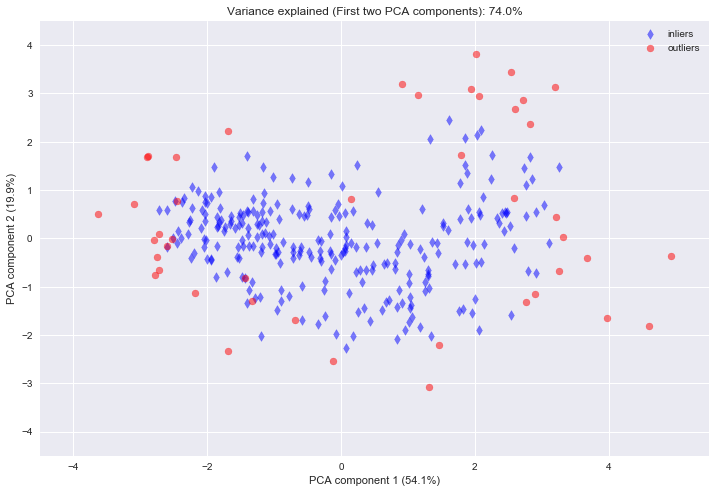

In [82]:
ax = draw_scatter_plot(inliers, outliers, reduced)

In [97]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")
assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")


## Practical Concepts

In [98]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn import preprocessing
from sklearn import svm
from sklearn import cross_validation as cv
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

In [99]:
file = 'leaf.csv'
leaves = pd.read_csv(file, names=['Class (Species)', 'Specimen Number', 'Eccentricity', 'Aspect Ratio',
                                  'Elongation', 'Solidity', 'Stochastic Convexity', 'Isoperimetric Factor', 
                                  'Maximal Indentation Depth', 'Lobedness', 'Average Intensity', 
                                  'Average Contrast', 'Smoothness', 'Third Moment', 'Uniformity', 'Entropy'])

leaves = leaves.drop('Specimen Number', axis=1)

In [100]:
print(leaves.head())

   Class (Species)  Eccentricity  Aspect Ratio  Elongation  Solidity  \
0                1       0.72694        1.4742     0.32396   0.98535   
1                1       0.74173        1.5257     0.36116   0.98152   
2                1       0.76722        1.5725     0.38998   0.97755   
3                1       0.73797        1.4597     0.35376   0.97566   
4                1       0.82301        1.7707     0.44462   0.97698   

   Stochastic Convexity  Isoperimetric Factor  Maximal Indentation Depth  \
0               1.00000               0.83592                   0.004657   
1               0.99825               0.79867                   0.005242   
2               1.00000               0.80812                   0.007457   
3               1.00000               0.81697                   0.006877   
4               1.00000               0.75493                   0.007428   

   Lobedness  Average Intensity  Average Contrast  Smoothness  Third Moment  \
0   0.003947           0.047790

In [101]:
f = leaves.drop('Class (Species)', axis=1)
c = leaves['Class (Species)'] 

### Feature Scaling

In [102]:
f_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(f), columns=f.columns)

### Feature Selection

In [120]:
def select_features_rfe(X, y, random_state, kernel='linear', C=1.0, num_attributes=3):
    '''
    Uses Support Vector Classifier as the estimator to rank features
    with Recursive Feature Elimination.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in SVC().
    kernel: A string. Used in SVC(). Default: "linear".
    C: A float. Used in SVC(). Default: 1.0.
    num_attributes: An int. The number of features to select in RFE. Default: 3.
    
    Returns
    -------
    A 3-tuple of (RFE, np.ndarray, np.ndarray)
    rfe: An RFE instance.
    columns: Selected column names. A numpy array of strings.
    ranking: The feature ranking. Selected features are assigned rank 1. A numpy array of integers.
    '''
    
    svc = svm.SVC(kernel=kernel, C=C, random_state=random_state)
    rfe = RFE(svc, num_attributes)
    rfe.fit(X,y)
    columns=X.columns[rfe.support_].values
    ranking=rfe.ranking_
    return rfe, columns, ranking

In [121]:
t_rfe, t_columns, t_ranking = select_features_rfe(f_scaled, c, check_random_state(0))

In [122]:
assert_is_instance(t_rfe, RFE)
assert_is_instance(t_ranking, np.ndarray)

assert_is_instance(t_rfe.estimator, svm.SVC)
assert_equal(t_rfe.estimator.kernel, 'linear')
assert_equal(t_rfe.estimator.C, 1)
assert_equal(t_rfe.n_features_, 3)

assert_array_equal(t_columns, ['Eccentricity', 'Isoperimetric Factor', 'Average Contrast'])
assert_array_equal(t_ranking, [1, 8, 2, 5, 10, 1, 3, 12, 11, 1, 9, 7, 6, 4])

In [154]:
def select_features_rfc(X, y, random_state, n_estimators=10, n_selected_columns=3):
    '''
    Uses Random Forest Classifier as the estimator to rank features.
    Sorts feature columns based on importances, and returns
    specified number of column names with highest importances.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    n_estimator: A float. Used in RandomForestClassifier(). Default: 10.
    n_selected_columns: An int. The number of features/columns to select. Default: 3.
    
    Returns
    -------
    A 3-tuple of (RFC, np.ndarray, np.ndarray)
    rfc: An RFC instance.
    columns: Selected column names. A numpy array of strings.
    importance: The feature importances. A numpy array of floats.
    '''
    
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_features=n_selected_columns, random_state=random_state)
    rfc.fit(X, y)
    importance=rfc.feature_importances_
    columns=X.columns[np.argsort(rfc.feature_importances_)[::-1][0:n_selected_columns]]
    return rfc, columns, importance

In [155]:
u_rfc, u_columns, u_importance = select_features_rfc(f_scaled, c, check_random_state(0))

In [156]:
assert_is_instance(u_rfc, RandomForestClassifier)
assert_is_instance(u_importance, np.ndarray)

assert_array_equal(u_columns, ['Eccentricity', 'Solidity', 'Entropy'])
assert_array_almost_equal(u_importance, 
                          [ 0.1004033 ,  0.0796833 ,  0.08358279,  0.09997119,  0.06706054,
                            0.08678733,  0.05865014,  0.07139296,  0.04943292,  0.04209375,
                            0.06102167,  0.04721591,  0.06452248,  0.08818172])

### Pipeline Anova RFC

In [157]:
def anova_rfc_pipeline(X, y, random_state, k=3, n_estimators=10, max_depth=4):
    '''
    Selects top k features with a pipeline that uses ANOVA F-value
    and a Random Forest Classifier.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    k: An int. The number of features to select. Default: 3.
    n_estimators: A float. Used by RandomForestClassifier(). Default: 10.
    max_depth: A float. Used by RandomForestClassifier(). Default: 4.
    
    Returns
    -------
    A 2-tuple of (Pipeline, np.ndarray)
    model: An ANOVA RFC pipeline.
    predictions: Classifications predicted by the pipeline.
    '''
    
    anova = SelectKBest(f_classif, k=k)
    rfc = RandomForestClassifier(n_estimators=n_estimators,random_state=random_state,max_depth=max_depth)
    anova_rfc = Pipeline([('anova', anova), ('rfc', rfc)])
    anova_rfc.fit(X,y)
    prediction = anova_rfc.predict(X)
    return anova_rfc, prediction

In [158]:
t_model, t_pred = anova_rfc_pipeline(f_scaled, c, random_state=check_random_state(0), n_estimators=30, max_depth=6)

In [159]:
assert_is_instance(t_model, Pipeline)
assert_equal(t_model.steps[0][0], 'anova')
assert_equal(t_model.steps[1][0], 'rfc')
assert_equal(t_model.get_params()['anova__k'], 3)
assert_equal(t_model.get_params()['rfc__n_estimators'], 30)
assert_equal(t_model.get_params()['rfc__max_depth'], 6)

assert_is_instance(t_pred, np.ndarray)
assert_equal(len(t_pred), 340)
assert_array_equal(t_pred[:15], [13,  1,  1,  1,  1, 13,  1,  1,  1, 14, 13,  1,  2,  2,  2])
assert_array_equal(t_pred[-15:], [35, 35, 35, 35, 12, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36])

### Grid Search

In [167]:
def find_best_max_depth(X, y, split_random_state, rfc_random_state, max_depth_values, test_size=0.2, n_estimators=10):
    '''
    Do a grid search to find the optimized max_depth parameter.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    split_random_state: A RandomState instance. Used in train_test_split().
    rfc_random_state: A RandomState instance. Used in RandomForestClassifier().
    max_depth_values: A np.array. A list of parameter settings to try as max_depth.
    test_size: A float. Used in train_test_split(). Default: 0.2.
    n_estimators: A float. Used by RandomForestEstimator(). Default: 10.

    Returns
    -------
    A 3-tuple of (GridSearchCV, float, float)
    model: A GridSearchCV instance.
    best_max_depth: The value of max_depth that gave the highest score.
    best_cv_score: Score of best_max_depth on the hold out data.
    '''
    
    (x_trn, x_tst, y_trn, y_tst) = cv.train_test_split(X, y, test_size=test_size,random_state=split_random_state)
    rfc = RandomForestClassifier(n_estimators,random_state=rfc_random_state)
    clf = GridSearchCV(estimator=rfc, param_grid=dict(max_depth=max_depth_values))
    clf.fit(x_trn, y_trn)
    best_max_depth=clf.best_estimator_.max_depth
    best_cv_score=clf.best_score_
    return clf, best_max_depth, best_cv_score

In [168]:
f_selected = f_scaled[t_columns] # use columns selected by RFE

model1, max_depth1, score1 = find_best_max_depth(f_selected, c, check_random_state(0), check_random_state(1), 
                                                 np.arange(1,12), test_size=0.3, n_estimators=20)
assert_is_instance(model1, GridSearchCV)
assert_is_instance(model1.estimator, RandomForestClassifier)
assert_equal(model1.estimator.n_estimators, 20)
assert_array_equal(model1.param_grid['max_depth'], np.arange(1,12))
assert_equal(max_depth1, 7)
assert_almost_equal(score1, 0.52941176470588236)

model2, max_depth2, score2 = find_best_max_depth(f_selected, c, check_random_state(2), check_random_state(2), 
                                                 np.arange(1,12), test_size=0.4, n_estimators=20)
assert_equal(max_depth2, 6)
assert_almost_equal(score2, 0.52450980392156865)

### Validation Curves

In [169]:
def get_mean_and_stdev(training_scores, testing_scores):
    '''
    Computes the means and standard deviations of the two input np.narrays.
    Helpful for making validation curves.
    
    Parameters
    ----------
    training_scores: A np.narray.
    testing_scores: A np.narray.
    
    Returns
    -------
    A tuple of 4 np.narrays, in the order of: mean of first input array, stdev of first input array, 
                                              mean of second input array, stdev of second input array.
    '''
    
    def mean_n_stdev(n):
        return n.mean(axis=1), n.std(axis=1)
    
    trn_mean, trn_std = mean_n_stdev(training_scores)
    tst_mean, tst_std = mean_n_stdev(testing_scores)
    
    return trn_mean, trn_std, tst_mean, tst_std

In [194]:
def plot_validation_curve(X, y, random_state, param_range=np.arange(1,20), cv=5):
    '''
    Computes and displays the validation curve for Random Forest Classfier.
    Plots the mean accuracy scores and fills the range of plus/minus 
    one standard deviation of the mean accuracy scores.
    Note: you need to plot the training score curve first and then 
          the cross validation score curve to pass assertions.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Classes.
    y: A pandas.DataFrame. Features.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    param_range: The values of the parameter that will be evaluated. Default: a list of ints from 1 to 20.
    cv: An int. Cross-Validation generator. Default: 5.
    
    Returns
    -------
    A maplotlib.Axes instance.
    '''
    
    trn_scr, tst_scr = validation_curve(RandomForestClassifier(random_state=random_state), X, y, param_name="max_depth", 
                                    param_range=param_range, cv=cv)
    trn_mean, trn_std, tst_mean, tst_std=get_mean_and_stdev(trn_scr, tst_scr)
    fig, ax = plt.subplots(figsize=(10,8))
    trn_color = sns.xkcd_rgb["yellow orange"]
    plt.plot(param_range, trn_mean, marker='o', c=trn_color, label='Training Score')
    plt.fill_between(param_range, trn_mean-trn_std, trn_mean+trn_std, color=trn_color, alpha=0.2)
    tst_color = color=sns.xkcd_rgb['sky blue']
    plt.plot(param_range, tst_mean, marker='o', c=tst_color, label='CV Score')
    plt.fill_between(param_range, tst_mean-tst_std, tst_mean+tst_std, color=tst_color, alpha=0.2)
    plt.title("Validation Curve (RFC)", fontsize=14)
    plt.xlabel('max_depth', fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 20)
    plt.ylim(0.1, 1.0)
    plt.legend(loc=4, fontsize=12)
    sns.despine()
    return ax

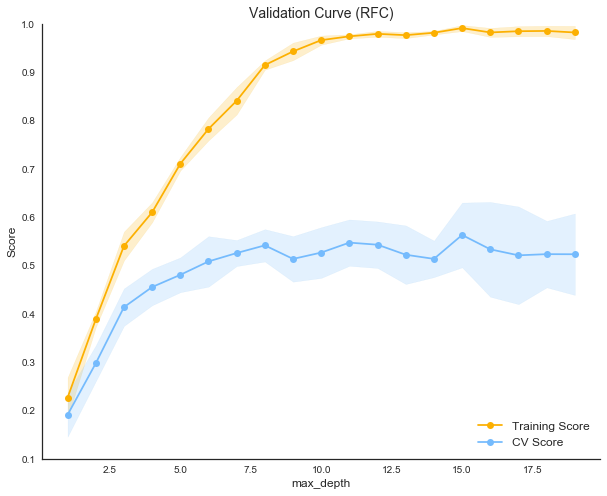

In [195]:
vc = plot_validation_curve(f_selected, c, check_random_state(0))

In [192]:
assert_is_instance(vc, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(vc.lines), 2)

assert_is_not(len(vc.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(vc.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(vc.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

# check lines
x_train, y_train = vc.lines[0].get_xydata().T
assert_array_almost_equal(x_train, np.arange(1,20))
assert_array_almost_equal(y_train, 
                          [ 0.22635556,  0.38835901,  0.54027221,  0.60997869,  0.71045737,
                            0.7825216 ,  0.84086324,  0.91471541,  0.94298356,  0.9663274 ,
                            0.9742014 ,  0.97935748,  0.97663546,  0.98165637,  0.99128017,
                            0.98225592,  0.98481485,  0.98539211,  0.98220311])

x_valid, y_valid = vc.lines[1].get_xydata().T
assert_almost_equal(x_valid, np.arange(1,20))
assert_array_almost_equal(y_valid, 
                        [ 0.19090551,  0.29747382,  0.41365137,  0.45535345,  0.48061187,
                          0.50834061,  0.52570965,  0.5416222 ,  0.51355724,  0.52669318,
                          0.54729495,  0.5429625 ,  0.52221434,  0.51364565,  0.56311908,
                          0.53339753,  0.52099856,  0.52343397,  0.5232402 ])

In [193]:
p_train, p_valid = vc.collections

path_train = p_train.get_paths()[0].vertices
assert_equal(len(path_train), 41)
assert_array_almost_equal(path_train[:5], 
                          [[ 1.        ,  0.26823345],
                           [ 1.        ,  0.18447767],
                           [ 2.        ,  0.37238893],
                           [ 3.        ,  0.51056177],
                           [ 4.        ,  0.58950553]])
assert_array_almost_equal(path_train[-5:], 
                          [[ 4.        ,  0.63045185],
                           [ 3.        ,  0.56998265],
                           [ 2.        ,  0.40432908],
                           [ 1.        ,  0.26823345],
                           [ 1.        ,  0.26823345]])

path_valid = p_valid.get_paths()[0].vertices
assert_equal(len(path_valid), 41)
assert_array_almost_equal(path_valid[:5], 
                          [[ 1.        ,  0.23597253],
                           [ 1.        ,  0.14583849],
                           [ 2.        ,  0.26051277],
                           [ 3.        ,  0.37502207],
                           [ 4.        ,  0.41773231]])
assert_array_almost_equal(path_valid[-5:],
                         [[ 4.        ,  0.49297459],
                          [ 3.        ,  0.45228068],
                          [ 2.        ,  0.33443486],
                          [ 1.        ,  0.23597253],
                          [ 1.        ,  0.23597253]])